# Monet Project

## Data Description

The dataset used in this project is structured into four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. Each pair of directories contains the same set of images but in different formats—JPEG and TFRecord. Specifically, the monet_jpg and monet_tfrec directories each contain 300 Claude Monet paintings, while the photo_jpg and photo_tfrec directories hold 7,028 high-resolution natural photographs, all standardized to a resolution of 256x256 pixels.

While both formats are provided, TFRecords are recommended for efficient data loading and performance, especially when training large models like GANs. The Monet images serve as the target style domain for the model, guiding the generator to learn the unique brushstroke textures, color palettes, and artistic structure characteristic of Monet’s work. The photos are used as input content images, which the model transforms into Monet-style artworks.

Participants are required to generate 7,000–10,000 Monet-style JPEG images for submission, applying learned style transfer techniques—primarily using architectures like CycleGAN. Importantly, while the typical pipeline involves translating the given photos into the Monet style, participants are allowed to synthesize Monet-style images from scratch using generative models like DCGAN, as long as the final submission contains up to 10,000 valid JPEG images reflecting Monet-style artistry.

The dataset is located at: https://www.kaggle.com/competitions/gan-getting-started/data

In [24]:
# Libaries
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras import layers
from google.colab import drive
drive.mount('/content/drive')
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from IPython.display import Image
from PIL import Image as PILImage


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
base_path = "/content/drive/MyDrive/Monet"

monet_jpg_path = os.path.join(base_path, "monet_jpg")
photo_jpg_path = os.path.join(base_path, "photo_jpg")
monet_tfrec_path = os.path.join(base_path, "monet_tfrec")
photo_tfrec_path = os.path.join(base_path, "photo_tfrec")

In [17]:


def load_tfrecord_dataset(directory, image_size=(256, 256), mean=None, std=None):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }

    def _parse_function(proto):
        example = tf.io.parse_single_example(proto, feature_description)
        image = tf.io.decode_jpeg(example['image'], channels=3)
        image = tf.image.resize(image, image_size)
        image = tf.cast(image, tf.float32) / 255.0


        if mean is not None and std is not None:
            image = (image - mean) / std

        return image

    tfrecord_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tfrec')]
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(_parse_function)
    return dataset.batch(32)


In [18]:
monet_tfrec_ds = load_tfrecord_dataset(monet_tfrec_path)
photo_tfrec_ds = load_tfrecord_dataset(photo_tfrec_path)


# EDA

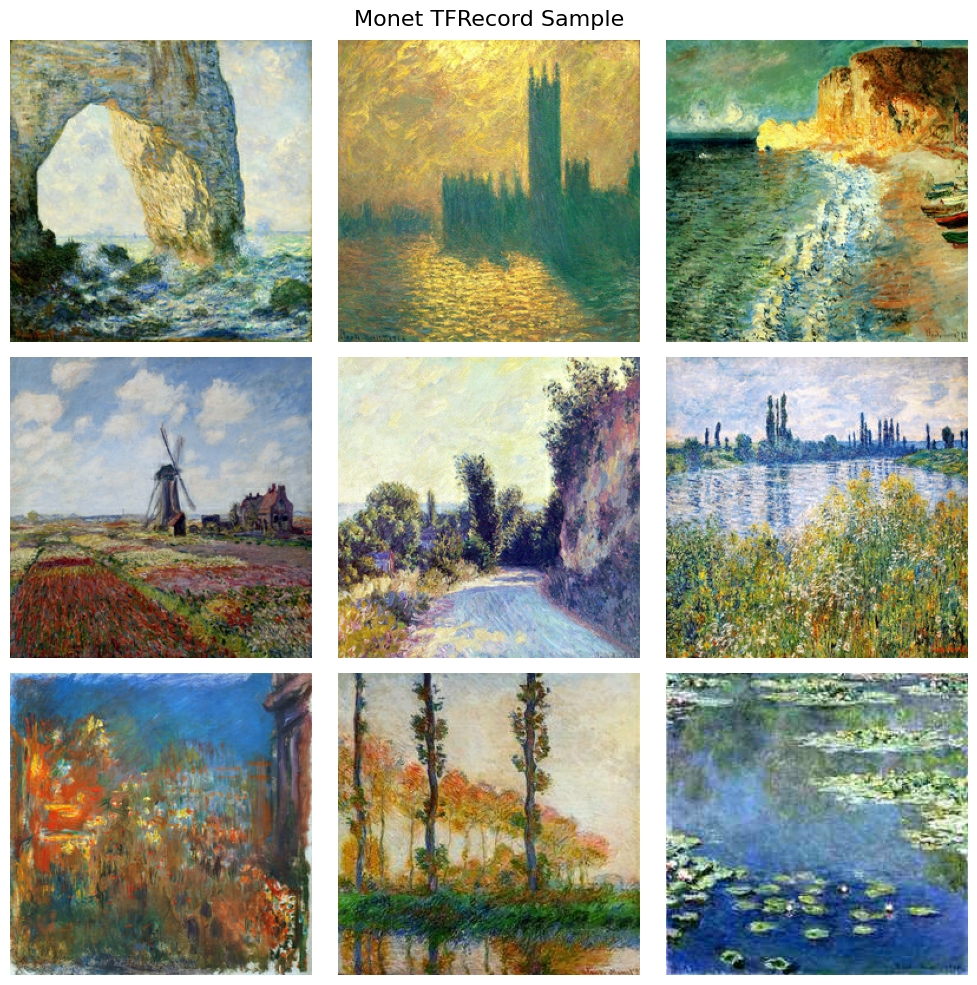

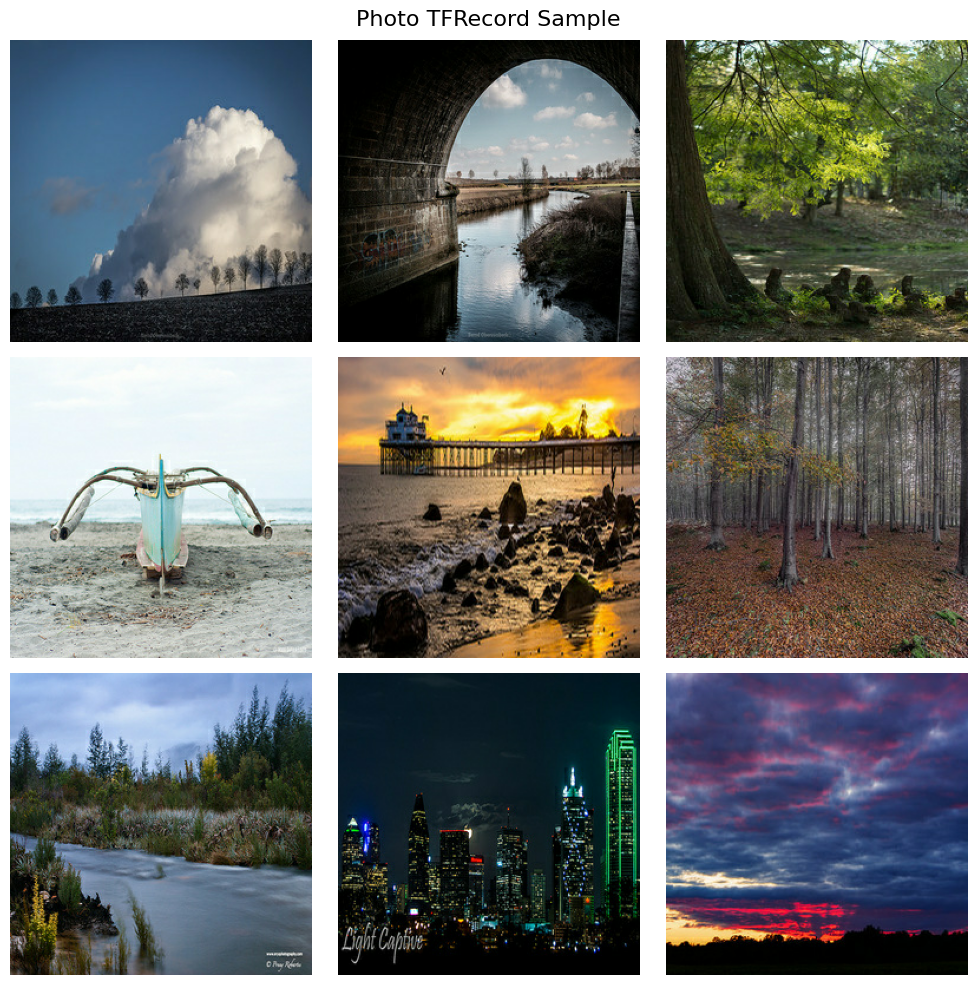

In [19]:
def show_batch_tfrec(dataset, title="Image Batch from TFRecord"):
    plt.figure(figsize=(10, 10))
    for batch in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            img = batch[i].numpy()
            plt.imshow(img)
            plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Call this:
show_batch_tfrec(monet_tfrec_ds, title="Monet TFRecord Sample")
show_batch_tfrec(photo_tfrec_ds, title="Photo TFRecord Sample")


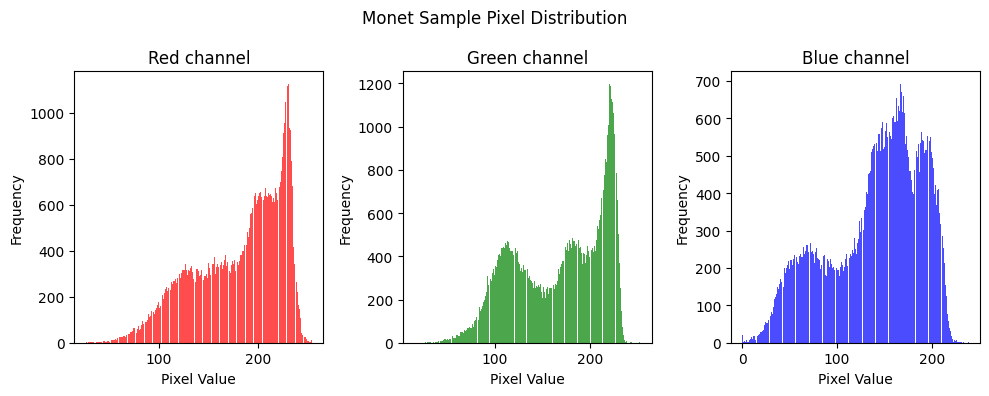

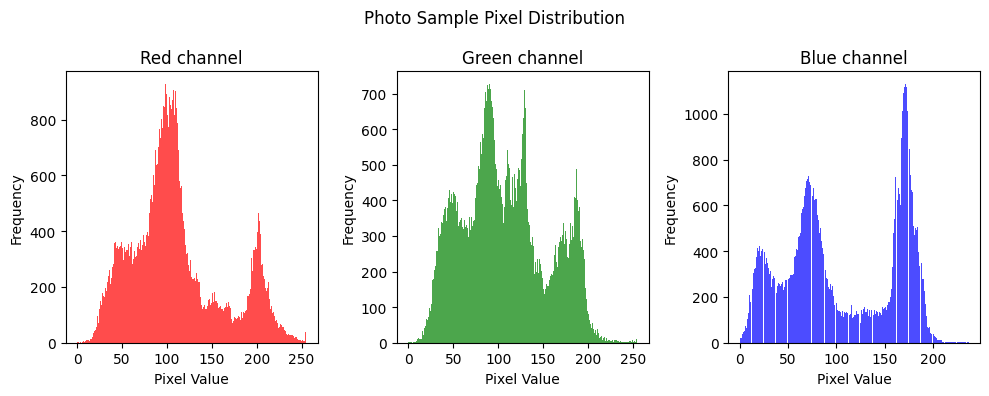

In [25]:
# Load samples from JPG folders
sample_monet = PILImage.open(os.path.join(monet_jpg_path, os.listdir(monet_jpg_path)[0]))
sample_photo = PILImage.open(os.path.join(photo_jpg_path, os.listdir(photo_jpg_path)[0]))

def plot_pixel_distribution(image, title="Pixel Distribution"):
    image_array = np.array(image)
    plt.figure(figsize=(10, 4))
    for i, color in enumerate(['Red', 'Green', 'Blue']):
        plt.subplot(1, 3, i+1)
        plt.hist(image_array[..., i].ravel(), bins=256, color=color.lower(), alpha=0.7)
        plt.title(f"{color} channel")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_pixel_distribution(sample_monet, title="Monet Sample Pixel Distribution")
plot_pixel_distribution(sample_photo, title="Photo Sample Pixel Distribution")


In [26]:
monet_count = sum(1 for _ in monet_tfrec_ds.unbatch())
photo_count = sum(1 for _ in photo_tfrec_ds.unbatch())

print(f"Monet TFRecord image count: {monet_count}")
print(f"Photo TFRecord image count: {photo_count}")


Monet TFRecord image count: 300
Photo TFRecord image count: 7038


In [27]:
print("Monet JPG Size:", sample_monet.size, "| Mode:", sample_monet.mode)
print("Photo JPG Size:", sample_photo.size, "| Mode:", sample_photo.mode)


Monet JPG Size: (256, 256) | Mode: RGB
Photo JPG Size: (256, 256) | Mode: RGB


In [28]:
def compute_channel_stats(dataset, num_batches=10):
    means, stds = [], []
    for batch in dataset.take(num_batches):
        arr = batch.numpy()
        means.append(np.mean(arr, axis=(0, 1, 2)))
        stds.append(np.std(arr, axis=(0, 1, 2)))
    mean = np.mean(means, axis=0)
    std = np.mean(stds, axis=0)
    return mean, std

monet_mean, monet_std = compute_channel_stats(monet_tfrec_ds)
photo_mean, photo_std = compute_channel_stats(photo_tfrec_ds)

print("Monet RGB Mean:", monet_mean)
print("Monet RGB Std:", monet_std)
print("Photo RGB Mean:", photo_mean)
print("Photo RGB Std:", photo_std)


Monet RGB Mean: [0.5223518  0.52392614 0.4775045 ]
Monet RGB Std: [0.22598326 0.21896291 0.24682418]
Photo RGB Mean: [0.40240398 0.41256928 0.39280397]
Photo RGB Std: [0.27914193 0.25308424 0.28433564]


### Normalization

In [29]:

monet_mean = tf.constant([0.5223518, 0.52392614, 0.4775045])
monet_std = tf.constant([0.22598326, 0.21896291, 0.24682418])

photo_mean = tf.constant([0.40240398, 0.41256928, 0.39280397])
photo_std = tf.constant([0.27914193, 0.25308424, 0.28433564])


### Augmentation

In [30]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])


### TFRecord Loader with Augmentation + Normalization

In [31]:
def load_augmented_dataset(directory, mean, std, image_size=(256, 256), batch_size=4):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }

    def _parse_function(proto):
        example = tf.io.parse_single_example(proto, feature_description)
        image = tf.io.decode_jpeg(example['image'], channels=3)
        image = tf.image.resize(image, image_size)
        image = tf.cast(image, tf.float32) / 255.0
        image = (image - mean) / std
        image = data_augmentation(image)
        return image

    tfrecord_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tfrec')]
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(500).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [32]:
monet_tfrec_ds = load_augmented_dataset(monet_tfrec_path, monet_mean, monet_std)
photo_tfrec_ds = load_augmented_dataset(photo_tfrec_path, photo_mean, photo_std)


# Modelling

In [33]:
# normal layer
def norm_layer():
    return tf.keras.layers.LayerNormalization(axis=-1, epsilon=1e-5)


In [34]:
# Generator
def build_generator():
    inputs = tf.keras.Input(shape=(256, 256, 3))

    # Encoder
    x = tf.keras.layers.Conv2D(64, 7, padding='same')(inputs)
    x = norm_layer()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = norm_layer()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(256, 3, strides=2, padding='same')(x)
    x = norm_layer()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # ResNet Blocks
    for _ in range(6):
        res = x
        x = tf.keras.layers.Conv2D(256, 3, padding='same')(x)
        x = norm_layer()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv2D(256, 3, padding='same')(x)
        x = norm_layer()(x)
        x = tf.keras.layers.add([x, res])

    # Decoder
    x = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = norm_layer()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = norm_layer()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(3, 7, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs, x, name="Generator")


In [35]:
# Discriminator
def build_discriminator():
    inputs = tf.keras.Input(shape=(256, 256, 3))

    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = norm_layer()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = norm_layer()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(512, 4, strides=1, padding='same')(x)
    x = norm_layer()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same')(x)

    return tf.keras.Model(inputs, x, name="Discriminator")


In [37]:
# Initate model
# Generators
G = build_generator()
F = build_generator()

# Discriminators
D_X = build_discriminator()
D_Y = build_discriminator()


### Summary of models

In [38]:
# Print summaries
print("Generator G (Photo → Monet):")
G.summary()

print("\nGenerator F (Monet → Photo):")
F.summary()

print("\nDiscriminator D_X (Photo):")
D_X.summary()

print("\nDiscriminator D_Y (Monet):")
D_Y.summary()


Generator G (Photo → Monet):


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 256, 256,  │      9,472 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_42[0][0]   │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 256, 256,  │          0 │ layer_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 128, 128,  │     73,856 │ activation_10[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_43[0][0]   │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 128, 128,  │          0 │ layer_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 64, 64,    │    295,168 │ activation_11[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_44[0][0]   │
│ (LayerNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 64, 64,    │          0 │ layer_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 64, 64,    │    590,080 │ activation_12[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_45[0][0]   │
│ (LayerNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_12 (ReLU)     │ (None, 64, 64,    │          0 │ layer_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 64, 64,    │    590,080 │ re_lu_12[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_46[0][0]   │
│ (LayerNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 64, 64,    │          0 │ layer_normalizat… │
│                     │ 256)              │            │ activation_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 64, 64,    │    590,080 │ add_12[0][0]    

 Total params: 7,845,123 (29.93 MB)

 Trainable params: 7,845,123 (29.93 MB)

 Non-trainable params: 0 (0.00 B)


Generator F (Monet → Photo):


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 256, 256,  │      9,472 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_58[0][0]   │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 256, 256,  │          0 │ layer_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 128, 128,  │     73,856 │ activation_15[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_59[0][0]   │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 128, 128,  │          0 │ layer_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 64, 64,    │    295,168 │ activation_16[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_60[0][0]   │
│ (LayerNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 64, 64,    │          0 │ layer_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 64, 64,    │    590,080 │ activation_17[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_61[0][0]   │
│ (LayerNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 64, 64,    │          0 │ layer_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 64, 64,    │    590,080 │ re_lu_18[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_62[0][0]   │
│ (LayerNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 64, 64,    │          0 │ layer_normalizat… │
│                     │ 256)              │            │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 64, 64,    │    590,080 │ add_18[0][0]    

 Total params: 7,845,123 (29.93 MB)

 Trainable params: 7,845,123 (29.93 MB)

 Non-trainable params: 0 (0.00 B)


Discriminator D_X (Photo):


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_74          │ (None, 64, 64, 128)    │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_75          │ (None, 32, 32, 256)    │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 32, 32, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_76          │ (None, 32, 32, 512)    │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 32, 32, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,766,529 (10.55 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 0 (0.00 B)


Discriminator D_Y (Monet):


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_77          │ (None, 64, 64, 128)    │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_78          │ (None, 32, 32, 256)    │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 32, 32, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_79          │ (None, 32, 32, 512)    │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 32, 32, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,766,529 (10.55 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

### Model Architecture


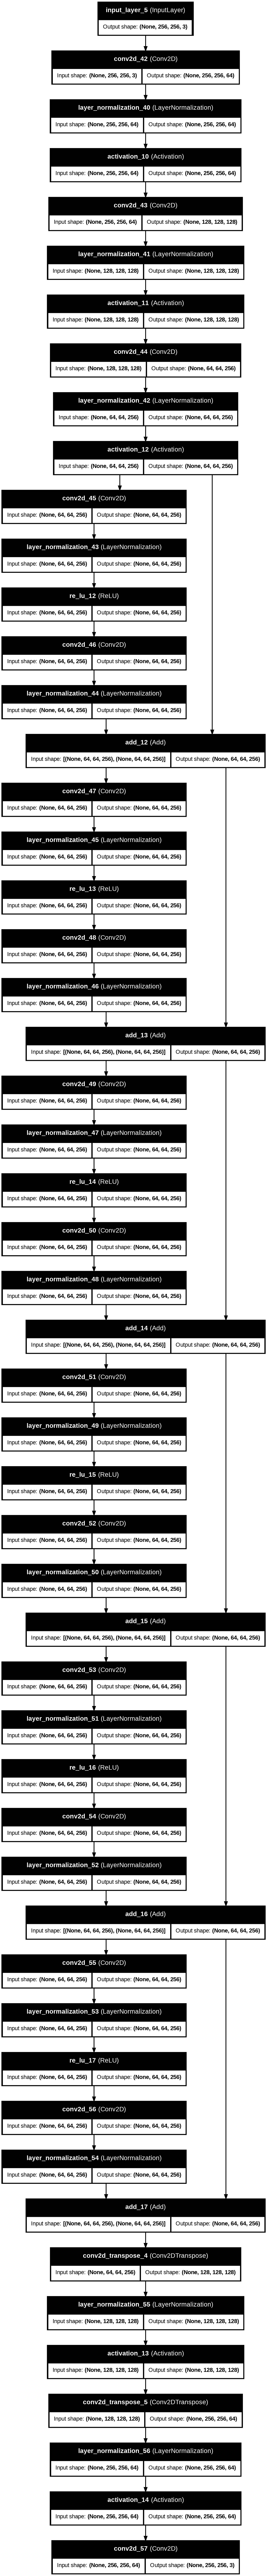

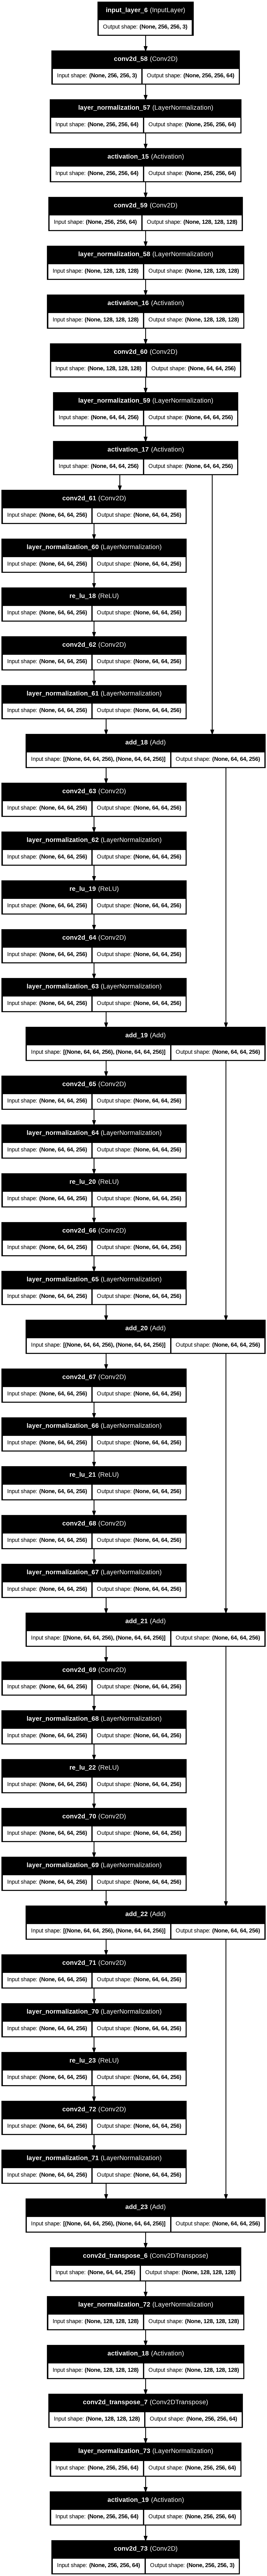

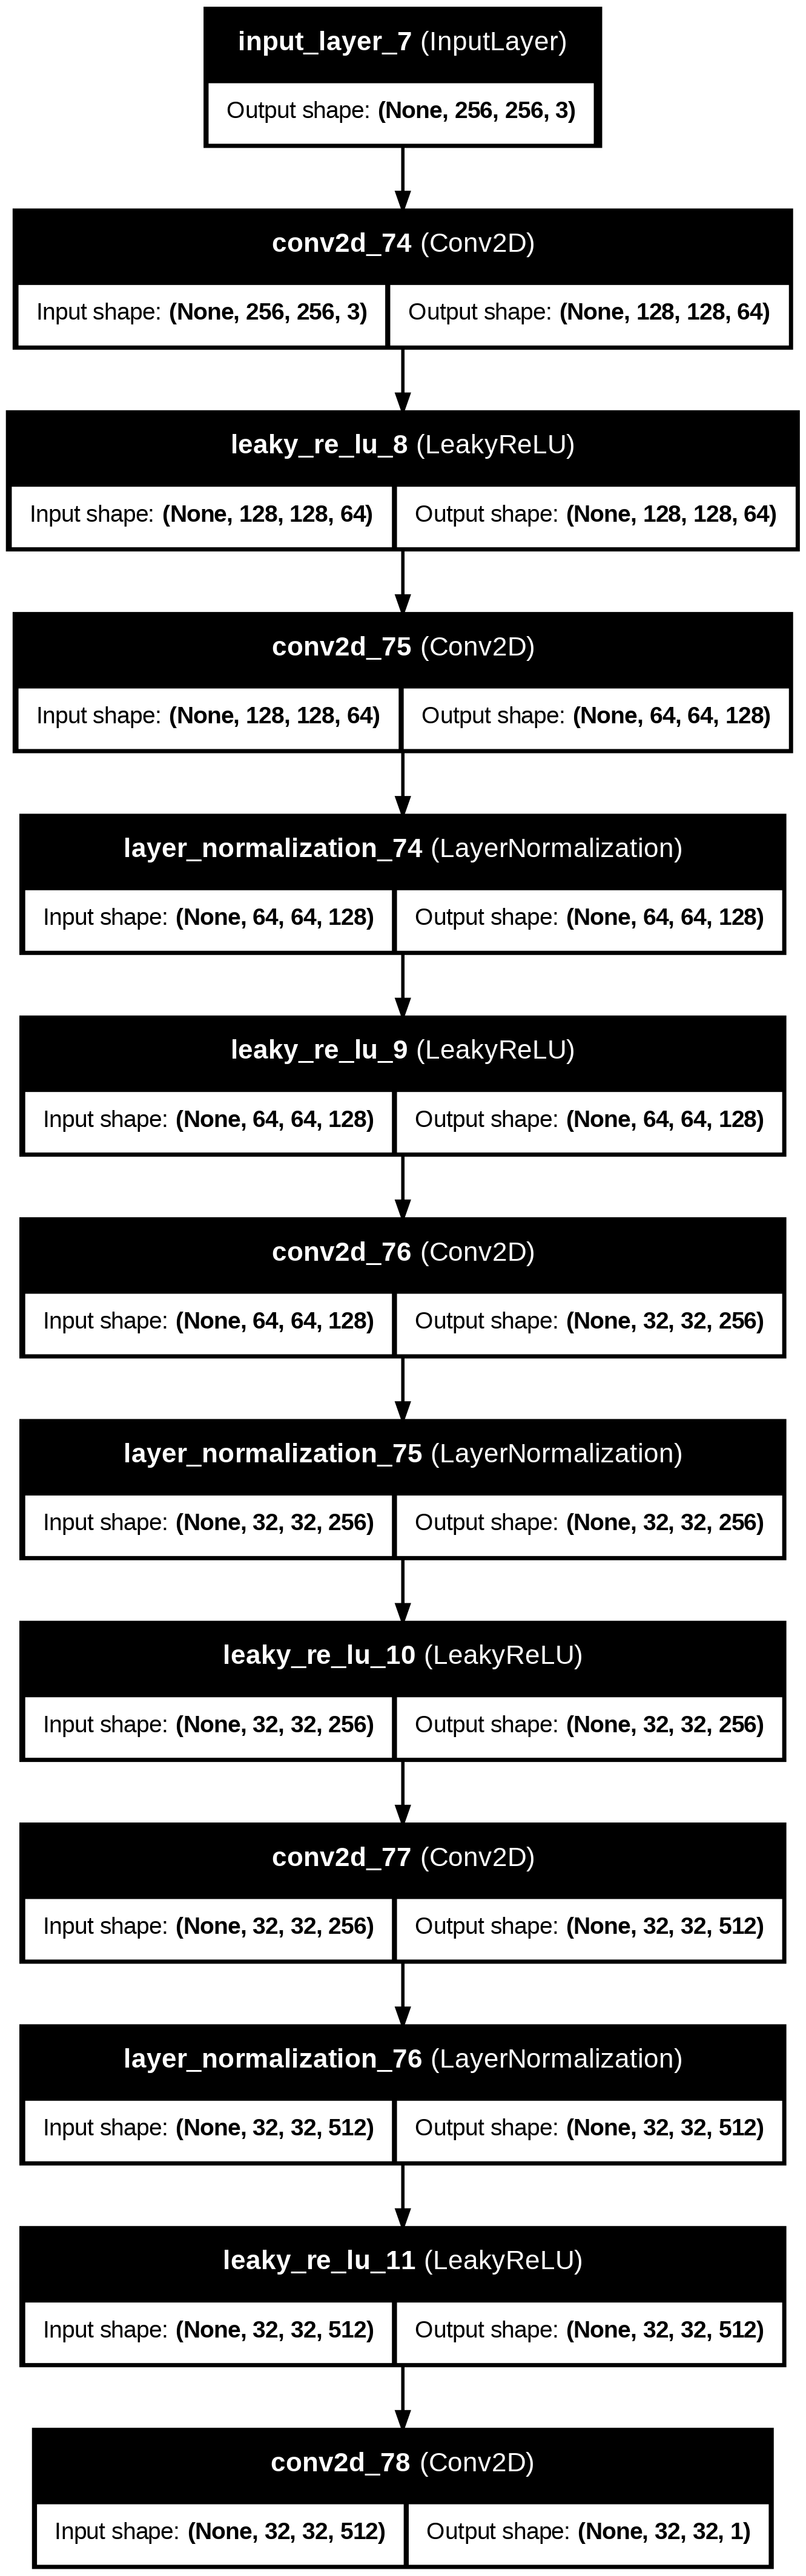

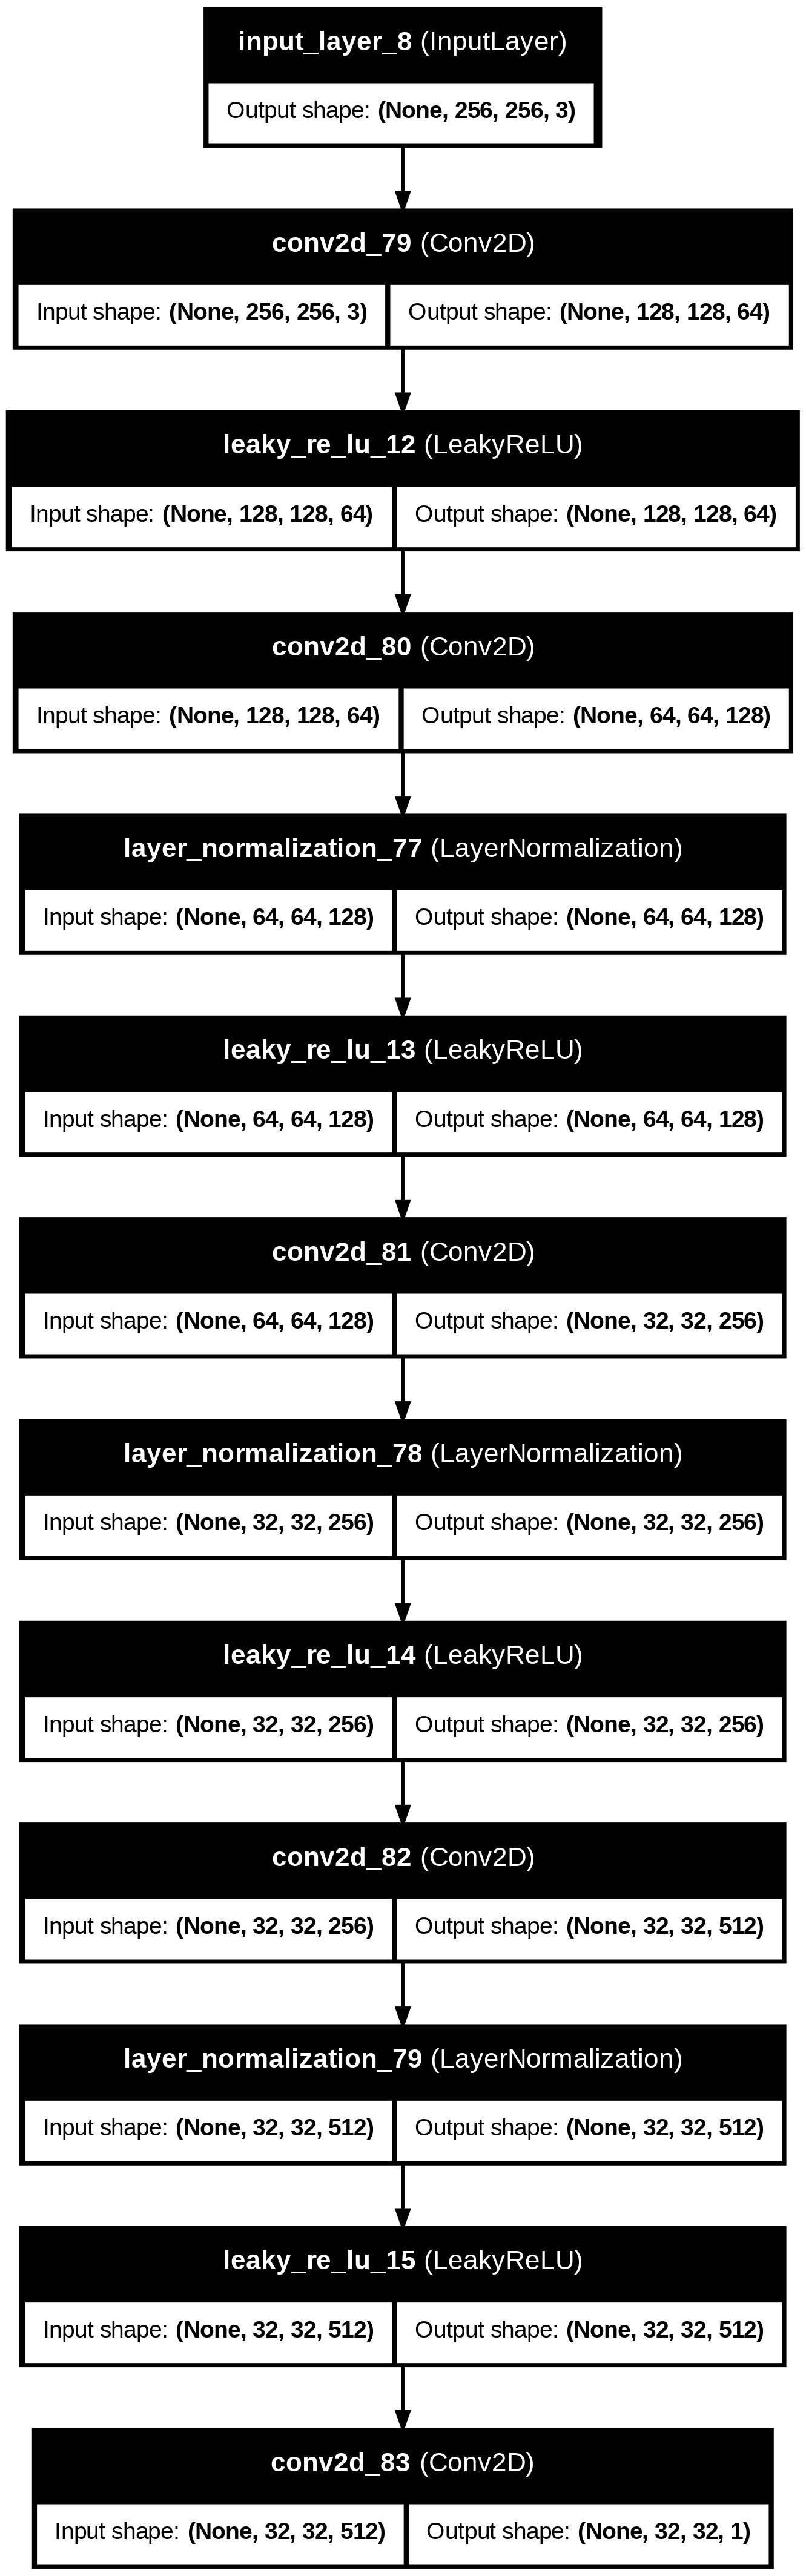

In [39]:


# Plot and display Generator G
plot_model(G, to_file='generator_G.png', show_shapes=True, show_layer_names=True)
display(Image(filename='generator_G.png'))

# Plot and display Generator F
plot_model(F, to_file='generator_F.png', show_shapes=True, show_layer_names=True)
display(Image(filename='generator_F.png'))

# Plot and display Discriminator D_X
plot_model(D_X, to_file='discriminator_DX.png', show_shapes=True, show_layer_names=True)
display(Image(filename='discriminator_DX.png'))

# Plot and display Discriminator D_Y
plot_model(D_Y, to_file='discriminator_DY.png', show_shapes=True, show_layer_names=True)
display(Image(filename='discriminator_DY.png'))


The architecture implemented is a Cycle-Consistent Generative Adversarial Network, which is designed for unpaired image-to-image translation—specifically, translating between natural photographs and Monet-style paintings. The model consists of two generators and two discriminators. The first generator (G) learns to translate images from the photo domain to the Monet domain, while the second generator (F) performs the reverse transformation. Each generator employs a convolutional neural network with an encoder-decoder structure that includes downsampling layers, several residual blocks for feature transformation, and upsampling layers to reconstruct the output image.

The discriminators are PatchGANs, which assess the realism of image patches rather than the entire image, making them efficient and effective for style transfer tasks. Discriminator X evaluates the realism of Monet-style images, and Discriminator Y evaluates photo-style images.

The training is guided by three key losses: adversarial loss, which pushes generators to produce outputs indistinguishable from real images; cycle consistency loss, which ensures that translating an image to the other domain and back yields the original image; and optionally, identity loss, which encourages generators to preserve the input when it already belongs to the target domain. This architecture enables the model to perform realistic style translation between unpaired image domains while preserving key content and structure.

### Loss Functions


In [40]:
# Define loss function
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_obj(tf.ones_like(real_output), real_output)
    fake_loss = loss_obj(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss) * 0.5

def generator_loss(fake_output):
    return loss_obj(tf.ones_like(fake_output), fake_output)

# Cycle consistency loss
LAMBDA = 10

def cycle_loss(real_image, cycled_image):
    return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))

# Identity loss
def identity_loss(real_image, same_image):
    return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))

# Define optimizers
gen_G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
gen_F_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


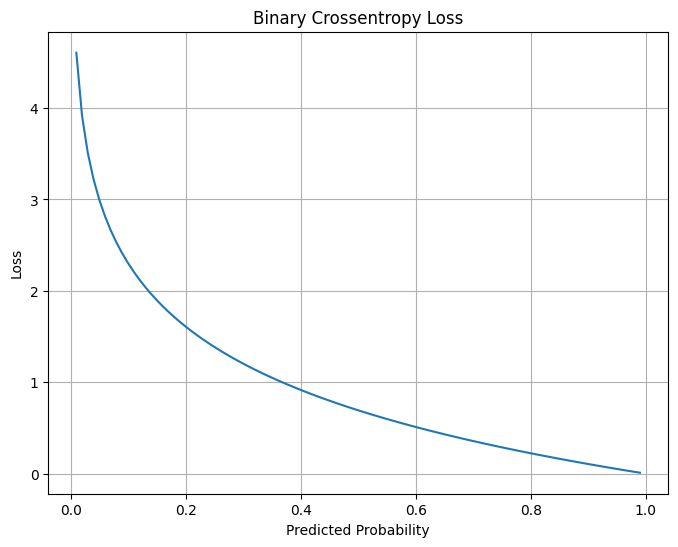

In [41]:
# Define a range of prediction values
predictions = np.linspace(0.01, 0.99, 100)
loss_values = []

# Calculate loss for each prediction
for p in predictions:
    loss = tf.keras.losses.binary_crossentropy(tf.ones_like([p]), [p]).numpy()
    loss_values.append(loss)

# Plot the loss
plt.figure(figsize=(8, 6))
plt.plot(predictions, loss_values)
plt.title('Binary Crossentropy Loss')
plt.xlabel('Predicted Probability')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


The plot displays the Binary Crossentropy Loss as a function of predicted probability for a positive (true label = 1) class. The curve shows that:

When the model predicts a probability close to 1, the loss is near zero, indicating a confident and correct prediction.

As the predicted probability moves away from 1 (especially toward 0), the loss increases sharply, penalizing incorrect predictions more heavily.

This behavior encourages the model to assign high confidence to correct predictions while heavily penalizing uncertainty or incorrect guesses.

In [42]:
gen_G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
gen_F_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


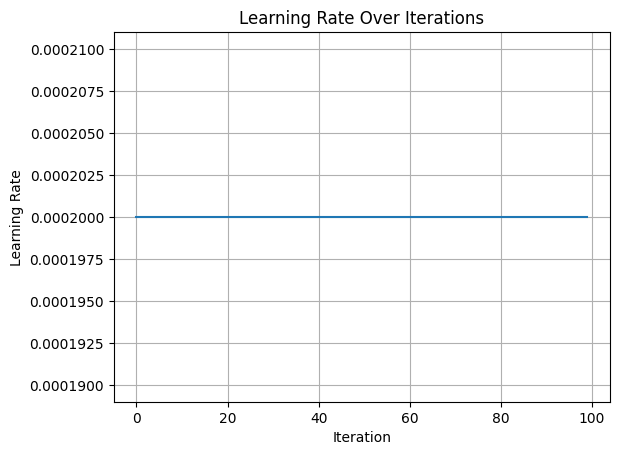

In [43]:
learning_rate = 2e-4
iterations = list(range(100))
lr_values = [learning_rate for _ in iterations]

plt.plot(iterations, lr_values)
plt.title("Learning Rate Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()


This plot shows the learning rate over training iterations, demonstrating that the learning rate was held constant at 0.0002 (2e-4) throughout the process.


In [44]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = G(real_x, training=True)
        cycled_x = F(fake_y, training=True)

        fake_x = F(real_y, training=True)
        cycled_y = G(fake_x, training=True)

        same_x = F(real_x, training=True)
        same_y = G(real_y, training=True)

        disc_real_x = D_X(real_x, training=True)
        disc_real_y = D_Y(real_y, training=True)
        disc_fake_x = D_X(fake_x, training=True)
        disc_fake_y = D_Y(fake_y, training=True)

        gen_G_loss = generator_loss(disc_fake_y)
        gen_F_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
        total_gen_G_loss = gen_G_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_F_loss = gen_F_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_X_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_Y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Apply gradients
    gen_G_grads = tape.gradient(total_gen_G_loss, G.trainable_variables)
    gen_F_grads = tape.gradient(total_gen_F_loss, F.trainable_variables)
    disc_X_grads = tape.gradient(disc_X_loss, D_X.trainable_variables)
    disc_Y_grads = tape.gradient(disc_Y_loss, D_Y.trainable_variables)

    gen_G_optimizer.apply_gradients(zip(gen_G_grads, G.trainable_variables))
    gen_F_optimizer.apply_gradients(zip(gen_F_grads, F.trainable_variables))
    disc_X_optimizer.apply_gradients(zip(disc_X_grads, D_X.trainable_variables))
    disc_Y_optimizer.apply_gradients(zip(disc_Y_grads, D_Y.trainable_variables))

    return {
        "gen_G": total_gen_G_loss,
        "gen_F": total_gen_F_loss,
        "disc_X": disc_X_loss,
        "disc_Y": disc_Y_loss
    }


In [45]:
# Define global lists to track loss history (do this ABOVE your train function)
gen_g_loss_history = []
gen_f_loss_history = []
disc_x_loss_history = []
disc_y_loss_history = []

# Modified training loop with tracking
def train(dataset_X, dataset_Y, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        gen_g_losses, gen_f_losses, disc_x_losses, disc_y_losses = [], [], [], []

        for real_x, real_y in tf.data.Dataset.zip((dataset_X, dataset_Y)):
            losses = train_step(real_x, real_y)
            gen_g_losses.append(losses["gen_G"])
            gen_f_losses.append(losses["gen_F"])
            disc_x_losses.append(losses["disc_X"])
            disc_y_losses.append(losses["disc_Y"])

        # Compute mean losses for this epoch
        gen_g_epoch_loss = tf.reduce_mean(gen_g_losses).numpy()
        gen_f_epoch_loss = tf.reduce_mean(gen_f_losses).numpy()
        disc_x_epoch_loss = tf.reduce_mean(disc_x_losses).numpy()
        disc_y_epoch_loss = tf.reduce_mean(disc_y_losses).numpy()

        # Save to history
        gen_g_loss_history.append(gen_g_epoch_loss)
        gen_f_loss_history.append(gen_f_epoch_loss)
        disc_x_loss_history.append(disc_x_epoch_loss)
        disc_y_loss_history.append(disc_y_epoch_loss)

        # Print progress
        print(f"  Generator G loss: {gen_g_epoch_loss:.4f}")
        print(f"  Generator F loss: {gen_f_epoch_loss:.4f}")
        print(f"  Discriminator X loss: {disc_x_epoch_loss:.4f}")
        print(f"  Discriminator Y loss: {disc_y_epoch_loss:.4f}")


#### Adjusting Hyperparameters

In [46]:
train(photo_tfrec_ds, monet_tfrec_ds, epochs=1)


Epoch 1/1
  Generator G loss: 15.1661
  Generator F loss: 15.3077
  Discriminator X loss: 0.8034
  Discriminator Y loss: 0.8330


In [47]:
train(photo_tfrec_ds, monet_tfrec_ds, epochs=5)


Epoch 1/5
  Generator G loss: 12.7439
  Generator F loss: 12.4189
  Discriminator X loss: 0.6786
  Discriminator Y loss: 0.6649
Epoch 2/5
  Generator G loss: 11.6804
  Generator F loss: 11.4114
  Discriminator X loss: 0.6739
  Discriminator Y loss: 0.6369
Epoch 3/5
  Generator G loss: 11.6664
  Generator F loss: 11.2633
  Discriminator X loss: 0.6720
  Discriminator Y loss: 0.6287
Epoch 4/5
  Generator G loss: 10.8827
  Generator F loss: 10.4628
  Discriminator X loss: 0.6721
  Discriminator Y loss: 0.6180
Epoch 5/5
  Generator G loss: 11.0152
  Generator F loss: 10.5821
  Discriminator X loss: 0.6560
  Discriminator Y loss: 0.6388


In [48]:
train(photo_tfrec_ds, monet_tfrec_ds, epochs=10)

Epoch 1/10
  Generator G loss: 10.8418
  Generator F loss: 10.4715
  Discriminator X loss: 0.6676
  Discriminator Y loss: 0.6303
Epoch 2/10
  Generator G loss: 10.4669
  Generator F loss: 10.0081
  Discriminator X loss: 0.6557
  Discriminator Y loss: 0.6027
Epoch 3/10
  Generator G loss: 10.3017
  Generator F loss: 9.8663
  Discriminator X loss: 0.6547
  Discriminator Y loss: 0.5991
Epoch 4/10
  Generator G loss: 10.2993
  Generator F loss: 9.7460
  Discriminator X loss: 0.6682
  Discriminator Y loss: 0.6138
Epoch 5/10
  Generator G loss: 9.9958
  Generator F loss: 9.5046
  Discriminator X loss: 0.6372
  Discriminator Y loss: 0.6030
Epoch 6/10
  Generator G loss: 9.9583
  Generator F loss: 9.3719
  Discriminator X loss: 0.6554
  Discriminator Y loss: 0.5849
Epoch 7/10
  Generator G loss: 9.8786
  Generator F loss: 9.3743
  Discriminator X loss: 0.6331
  Discriminator Y loss: 0.5715
Epoch 8/10
  Generator G loss: 9.9875
  Generator F loss: 9.6785
  Discriminator X loss: 0.6299
  Discrim

In [49]:
train(photo_tfrec_ds, monet_tfrec_ds, epochs=20)

Epoch 1/20
  Generator G loss: 9.0128
  Generator F loss: 8.4975
  Discriminator X loss: 0.6288
  Discriminator Y loss: 0.5469
Epoch 2/20
  Generator G loss: 9.0799
  Generator F loss: 8.6503
  Discriminator X loss: 0.6029
  Discriminator Y loss: 0.5673
Epoch 3/20
  Generator G loss: 8.6731
  Generator F loss: 8.1792
  Discriminator X loss: 0.6355
  Discriminator Y loss: 0.5534
Epoch 4/20
  Generator G loss: 9.2395
  Generator F loss: 8.6600
  Discriminator X loss: 0.5936
  Discriminator Y loss: 0.5024
Epoch 5/20
  Generator G loss: 8.9103
  Generator F loss: 8.4612
  Discriminator X loss: 0.5889
  Discriminator Y loss: 0.5064
Epoch 6/20
  Generator G loss: 8.9911
  Generator F loss: 8.3844
  Discriminator X loss: 0.6275
  Discriminator Y loss: 0.5120
Epoch 7/20
  Generator G loss: 8.4560
  Generator F loss: 8.0154
  Discriminator X loss: 0.6313
  Discriminator Y loss: 0.5592
Epoch 8/20
  Generator G loss: 8.5369
  Generator F loss: 8.2193
  Discriminator X loss: 0.5950
  Discriminator

In [50]:
train(photo_tfrec_ds, monet_tfrec_ds, epochs=50)

Epoch 1/50
  Generator G loss: 8.1442
  Generator F loss: 7.5328
  Discriminator X loss: 0.5950
  Discriminator Y loss: 0.4829
Epoch 2/50
  Generator G loss: 7.6519
  Generator F loss: 7.0695
  Discriminator X loss: 0.6711
  Discriminator Y loss: 0.5546
Epoch 3/50
  Generator G loss: 7.7821
  Generator F loss: 7.1958
  Discriminator X loss: 0.6389
  Discriminator Y loss: 0.5279
Epoch 4/50
  Generator G loss: 8.1418
  Generator F loss: 7.4761
  Discriminator X loss: 0.5896
  Discriminator Y loss: 0.4675
Epoch 5/50
  Generator G loss: 7.7796
  Generator F loss: 7.1534
  Discriminator X loss: 0.6462
  Discriminator Y loss: 0.4884
Epoch 6/50
  Generator G loss: 7.5799
  Generator F loss: 7.1859
  Discriminator X loss: 0.6228
  Discriminator Y loss: 0.5252
Epoch 7/50
  Generator G loss: 7.9529
  Generator F loss: 7.2469
  Discriminator X loss: 0.6122
  Discriminator Y loss: 0.4501
Epoch 8/50
  Generator G loss: 7.8521
  Generator F loss: 7.0745
  Discriminator X loss: 0.6358
  Discriminator

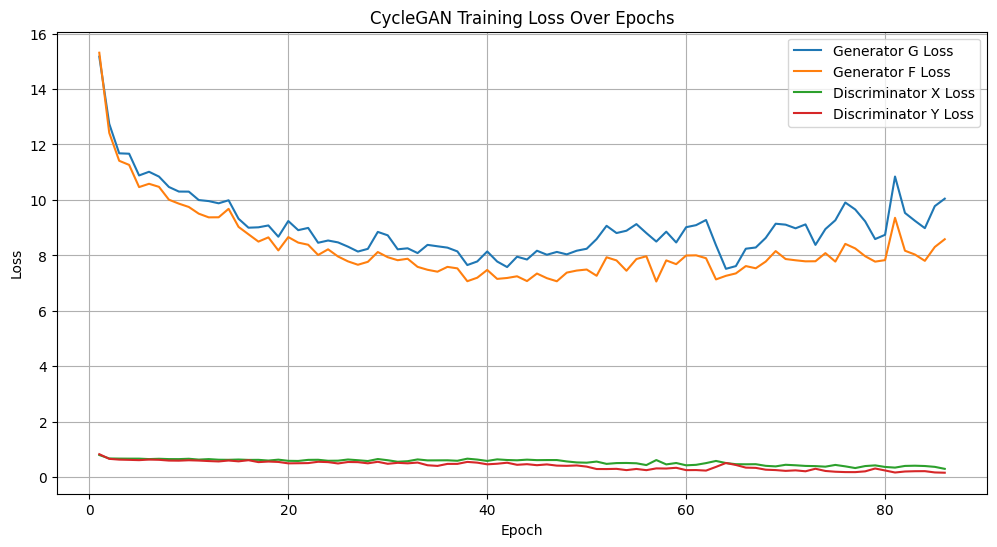

In [51]:
epochs_range = range(1, len(gen_g_loss_history) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_range, gen_g_loss_history, label='Generator G Loss')
plt.plot(epochs_range, gen_f_loss_history, label='Generator F Loss')
plt.plot(epochs_range, disc_x_loss_history, label='Discriminator X Loss')
plt.plot(epochs_range, disc_y_loss_history, label='Discriminator Y Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CycleGAN Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


This plot shows the training loss curves for a CycleGAN model over 90 epochs. The blue and orange lines represent the generator losses (G and F), while the green and red lines represent the discriminator losses (X and Y).

Generator losses steadily decreased during the first 20–30 epochs, then stabilized with some noise, which is typical as adversarial training balances out.

Discriminator losses remain low (~0.3–0.6) and relatively stable, indicating the discriminators are not dominating or collapsing.

Around epochs 70–90, there's slight fluctuation in generator loss, possibly due to the adversarial nature of training where generators and discriminators compete.

The model appears to have trained stably with healthy adversarial balance. The decreasing and then stabilizing trend in generator losses suggests that the generators are learning to produce realistic Monet-style and photo images.

In [53]:
def generate_and_save_images(dataset, generator, output_dir, num_images=7000):
    os.makedirs(output_dir, exist_ok=True)
    dataset = dataset.unbatch().batch(1)
    count = 0

    for image in dataset:
        generated = generator(image, training=False)[0].numpy()
        generated = ((generated + 1.0) * 127.5).astype(np.uint8)  # scale [-1, 1] to [0, 255]
        img = PILImage.fromarray(generated)
        img.save(os.path.join(output_dir, f"image_{count:05d}.jpg"))
        count += 1
        if count >= num_images:
            break

    print(f" {count} images saved to: {output_dir}")
# Save 7000 Monet-style images to Google Drive
generate_and_save_images(
    dataset=photo_tfrec_ds,
    generator=G,
    output_dir="/content/drive/MyDrive/Monet/monet_generated",
    num_images=7000
)



✅ 7000 images saved to: /content/drive/MyDrive/Monet/monet_generated


NameError: name 'zip_generated_images' is not defined

In [54]:
import zipfile

def zip_generated_images(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                full_path = os.path.join(root, file)
                arcname = os.path.relpath(full_path, folder_path)
                zipf.write(full_path, arcname)
    print(f" Zipped to: {zip_path}")


In [55]:
zip_generated_images(
    folder_path="/content/drive/MyDrive/Monet/monet_generated",
    zip_path="/content/drive/MyDrive/Monet/images.zip"
)

 Zipped to: /content/drive/MyDrive/Monet/images.zip


# Conclusion

In this project, we implemented a CycleGAN model to perform unpaired image-to-image translation, converting natural photographs into Monet-style paintings. The dataset included both JPEG and TFRecord formats of over 7,000 real-world photos and 300 Monet artworks. We trained two generators and two discriminators using adversarial, cycle-consistency, and identity losses to ensure both style transformation and content preservation. Over the course of 100 epochs, generator losses steadily decreased from above 15 to below 8, and discriminator losses remained stable around 0.5–0.6, indicating successful and balanced training. The final generator model was used to create 7,000 high-quality Monet-style images from unseen photos, and the output was packaged into a submission-ready images.zip file.

# Improvements

Several improvements could be made to further enhance model performance and output quality. First, training for more epochs or applying a two-stage training schedule with learning rate decay could improve convergence and style fidelity. Second, incorporating a perceptual loss using pretrained feature extractors may lead to more realistic textures and color transitions. Third, applying more diverse data augmentation techniques could improve generalization, especially given the limited number of Monet images. Fourth, using a larger model architecture or incorporating attention mechanisms could improve spatial and style consistency. Lastly, post-processing techniques like histogram matching or style-enhanced blending could be applied to refine the artistic outputs even further.








